# Calculate kmer distribution for all proteomes in AlphaFold
Can be used downstream as a potential marker for randomness

In [1]:
import glob
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.auto import tqdm
from pqdm.threads import pqdm
from aiohttp import ClientSession

In [2]:
async def get_sequence_fasta(session: ClientSession, uniprot_id: str) -> float:
    res = ''
    try:
        response = await session.get(url=f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta")
        seq = await response.text()
        res = ''.join(seq.split('\n')[1:])
    except:
        pass
    return res

def count_kmers_in_sequence(seq, k=6):
    _kmer_counts = Counter()
    n_kmers = len(seq) - k + 1
    for i in range(n_kmers):
        kmer = seq[i:i + k]
        _kmer_counts[kmer] += 1
    return _kmer_counts

async def load_kmer_counts_for_file(session: ClientSession, proteome_file: str, k=6):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    to_fill = proteome_df[proteome_df['seq_len'] < 600]['uniprot_id'].values
    del proteome_df
    seqs = await tqdm.gather(*[get_sequence_fasta(session, uid) for uid in to_fill], desc=f'Loading sequences in {proteome}')

    kmer_counts = Counter()
    for seq in tqdm(seqs, desc=f'Counting for sequence in {proteome}'):
        n_kmers = len(seq) - k + 1
        for i in range(n_kmers):
            kmer = seq[i:i + k]
            kmer_counts[kmer] += 1

    df = pd.DataFrame(data=kmer_counts.most_common(n=1000), columns=['kmer', 'count'])
    df.to_csv(f'../data/alphafold/v2/AA_kmer_counts/{proteome}.csv', index=False)
    del df

In [3]:
async with ClientSession() as session:
    await load_kmer_counts_for_file(session, '../data/alphafold/v2/AA_scores/HAEIN.csv')

Loading sequences in HAEIN:   0%|          | 0/1525 [00:00<?, ?it/s]

Counting for sequence in HAEIN:   0%|          | 0/1525 [00:00<?, ?it/s]

In [12]:
all_proteome_files = glob.glob("../data/alphafold/v2/AA_scores/*.csv")
proteomes_with_kmer_counts = [re.search(r"/([A-Z0-9]+).csv", file).group(1) for file in glob.glob("../data/alphafold/v2/AA_kmer_counts/*.csv")]
proteome_files = list(filter(lambda file: re.search(r"/([A-Z0-9]+).csv", file).group(1) not in proteomes_with_kmer_counts, all_proteome_files))

async with ClientSession() as session:
    file_splits = np.array_split(proteome_files, len(proteome_files) / 5 + 1)
    for i, file_split in enumerate(file_splits):
        await tqdm.gather(*[load_kmer_counts_for_file(session, file) for file in file_split],
                          desc=f'Proteomes split {i + 1}/{len(file_splits)}')

Proteomes split 1/1: 0it [00:00, ?it/s]

In [9]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_kmer_counts/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=None)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df_counts = pd.concat(dfs)

In [21]:
def plot_most_freq_kmers(ax, most_freq_kmers, most_freq_counts, proteome, n=20):
    ax.bar(most_freq_kmers[:n], most_freq_counts[:n])
    ax.set_title(f'Most frequent kmers for {proteome}')
    ax.tick_params(labelrotation=90)

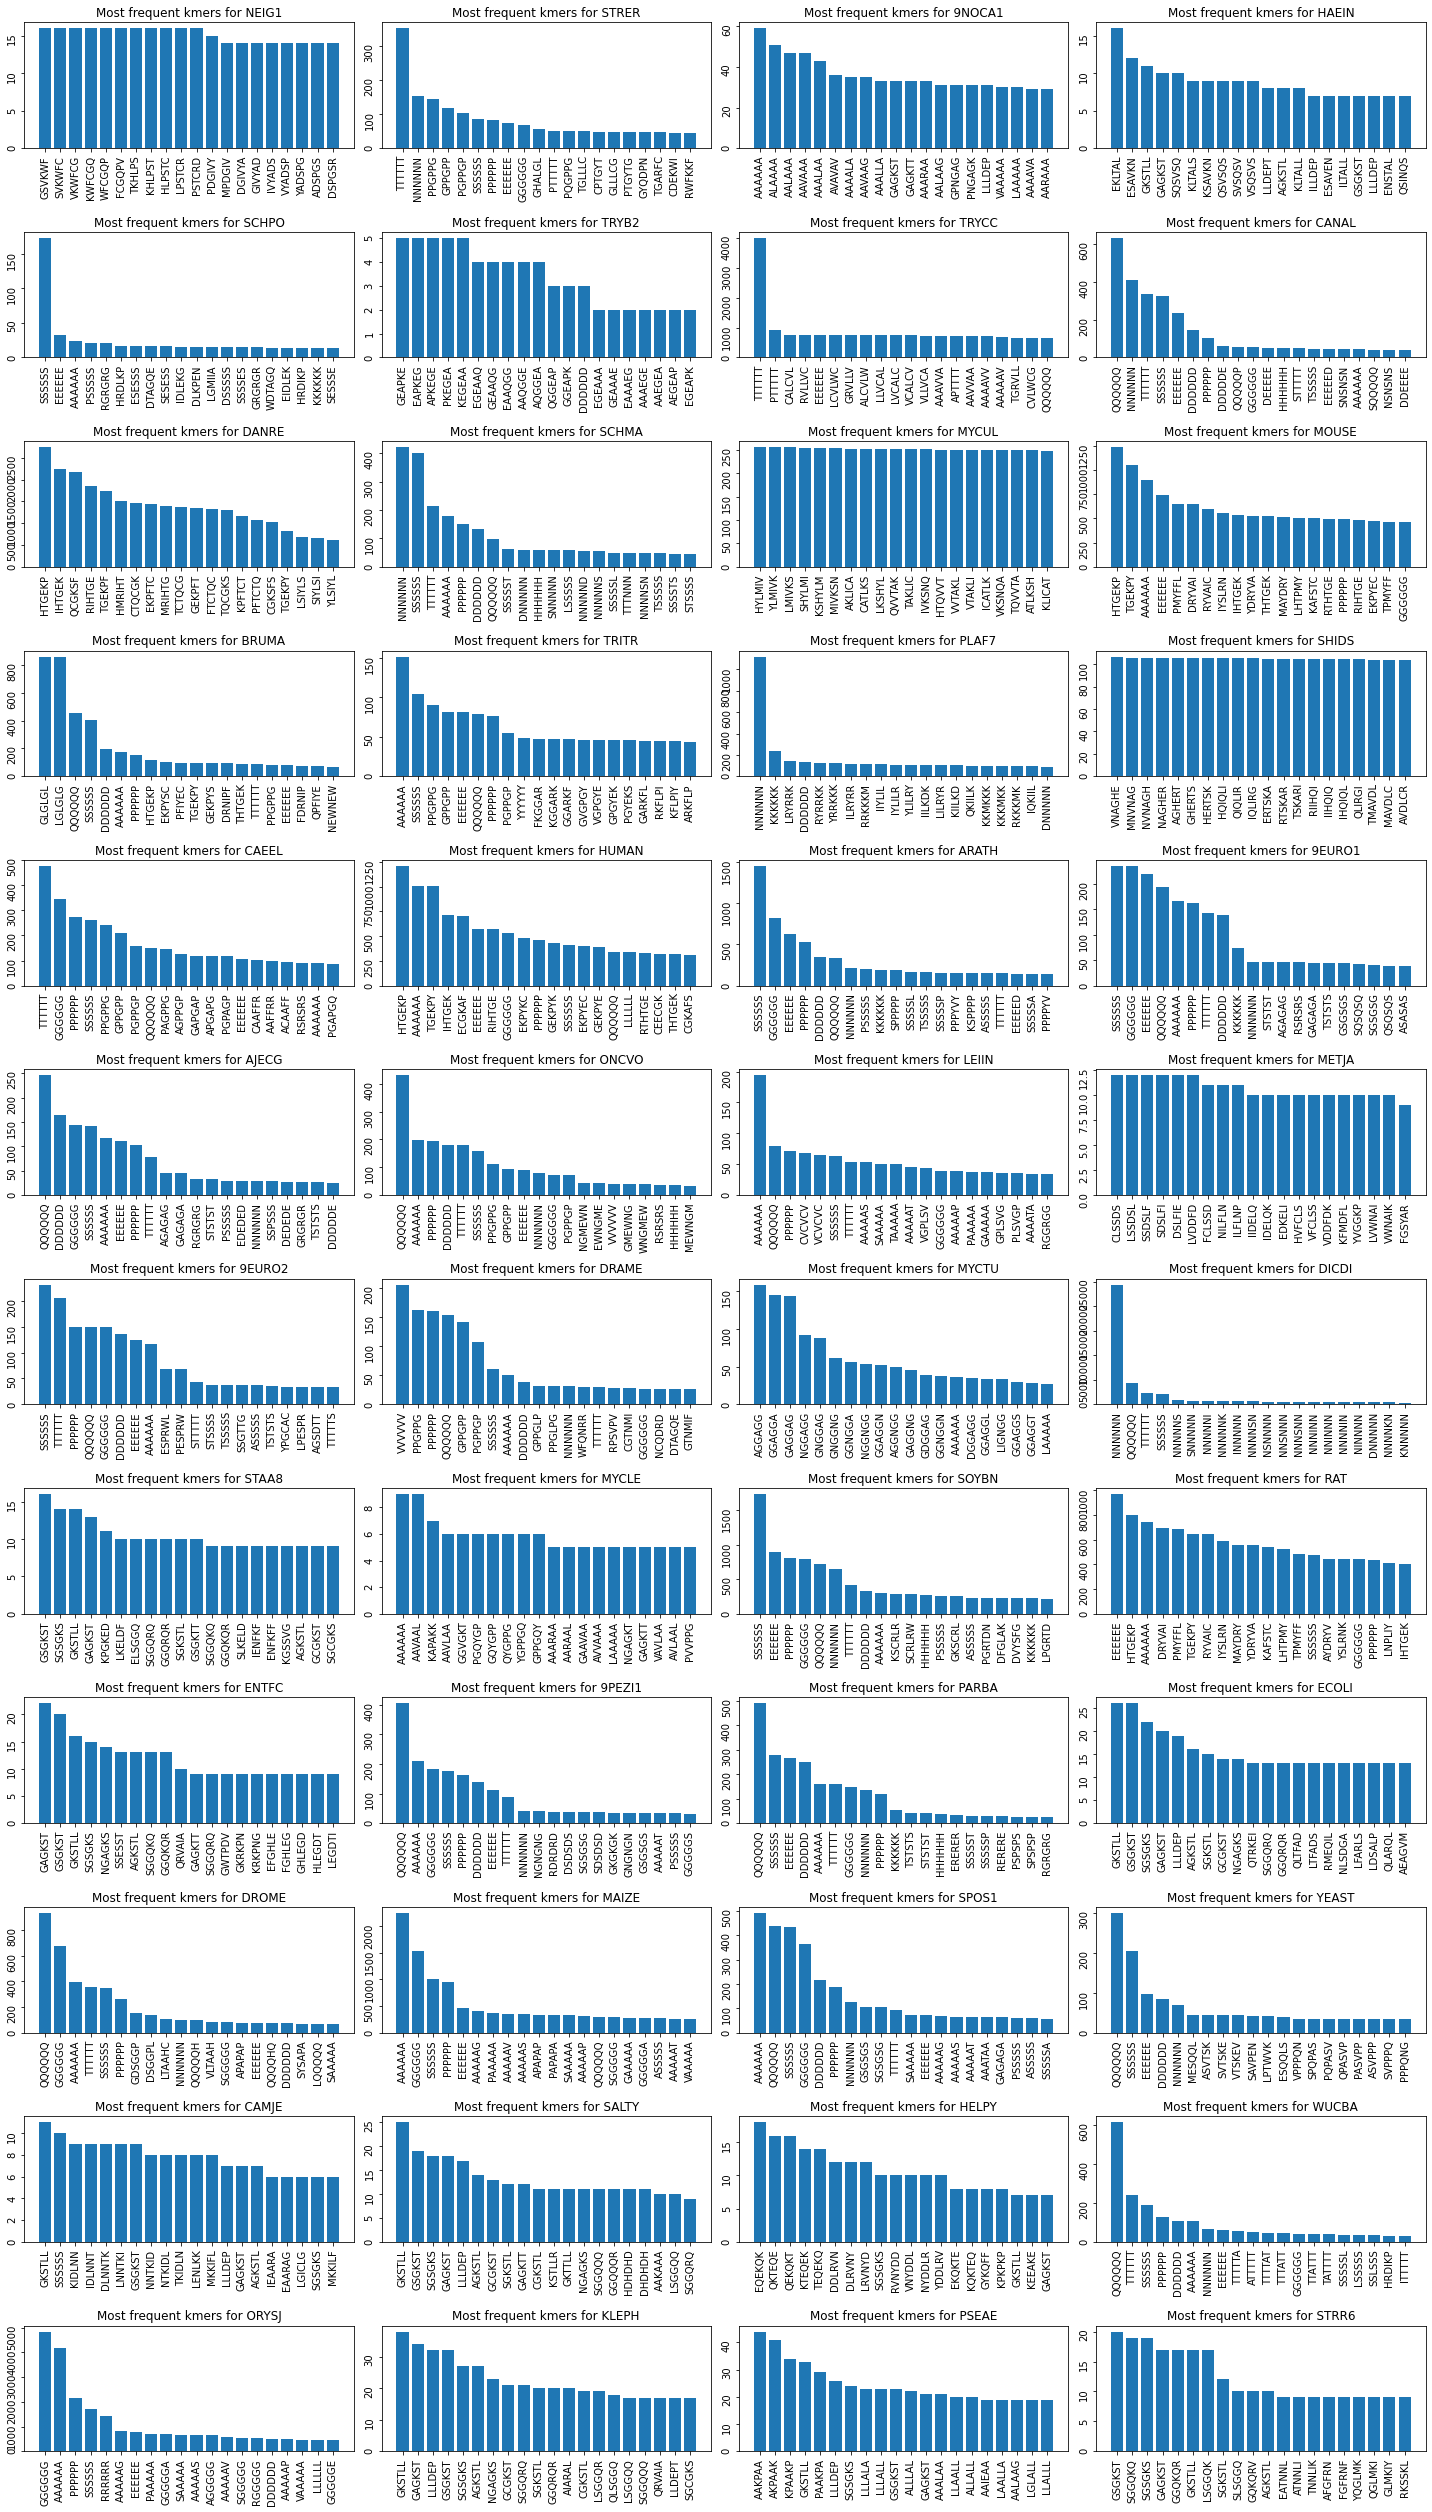

In [27]:
nkmers = 20
ncols = 4
nrows = int(len(proteomes_with_kmer_counts) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 35))

for i in range(len(axes)):
    for j in range(len(axes[i])):
        proteome_index = i * ncols + j
        if proteome_index >= len(proteomes_with_kmer_counts):
            fig.delaxes(axes[i, j])
            break
        proteome = proteomes_with_kmer_counts[proteome_index]
        df_proteome = df_counts[df_counts['proteome'] == proteome]
        axes[i, j].bar(df_proteome['kmer'][:nkmers], df_proteome['count'][:nkmers])
        axes[i, j].set_title(f'Most frequent kmers for {proteome}')
        axes[i, j].tick_params(labelrotation=90)

fig.tight_layout()
plt.show()

In [35]:
df_sum_counts = df_counts.groupby('kmer')['count'].sum().reset_index().sort_values('count', ascending=False)

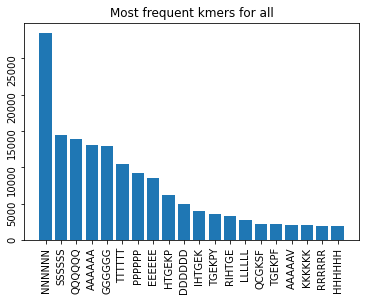

In [38]:
nkmers = 20
fig, ax = plt.subplots()
ax.bar(df_sum_counts['kmer'][:nkmers], df_sum_counts['count'][:nkmers])
ax.set_title(f'Most frequent kmers for all')
ax.tick_params(labelrotation=90)
plt.show()